In [2]:
import numpy as np 
import pandas as pd 

import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt 
import seaborn as sns 
import missingno as msno

import sqlite3 as sql 

- The european soccer database is about soccer matches from 2008 to 2016, consist of players' attributes, countries, teams' attributes, and match information.

In [3]:
def my_histogram(df, column_name):
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex = True, gridspec_kw = {"height_ratios": (.2, .8)}, figsize = (10, 7))

    sns.boxplot(x = df[column_name], ax = ax_box, showfliers = False)
    sns.histplot(x = df[column_name], ax = ax_hist, kde = True)

    plt.grid()
    plt.xlabel(column_name, fontsize = 16)
    plt.ylabel("Count", fontsize = 16)
    ax_box.set_xlabel("")

    plt.show()

# 1. Load the data

In [4]:
con = sql.connect("database.sqlite")

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
sql_master_tables = pd.read_sql('select * from sqlite_master where type="table";',con)
sql_master_tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [7]:
pd.read_sql(
    "select * from sqlite_sequence", con
    )

,name,seq
0,Team,103916
1,Country,51958
2,League,51958
3,Match,51958
4,Player,11075
5,Player_Attributes,183978
6,Team_Attributes,1458


- There are 7 tables.

## 1.1. Player related data

### 1.1.1. Player table

In [8]:
df_player = pd.read_sql(
    "select * from Player", con
    )

df_player.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [9]:
df_player.shape

(11060, 7)

In [10]:
len(df_player.player_api_id.unique())

11060

In [11]:
len(df_player.player_fifa_api_id.unique())

11060

In [12]:
sum(df_player.groupby(["player_api_id","player_fifa_api_id"]).count().id != 1)

0

- There are total 11,060 soccer players and their birthday, height, weight information.
- Each player has exactly one player_api_id, one player_fifa_api_id, and one (player_api_id, player_fifa_api_id) set. So, we can use any player id to identify a player.

In [13]:
df_player.isna().sum()

id                    0
player_api_id         0
player_name           0
player_fifa_api_id    0
birthday              0
height                0
weight                0
dtype: int64

- There is no missing value in the Player table.

### 1.1.2. Player_attributes table

In [14]:
df_player_attr = pd.read_sql(
    "select * from Player_Attributes", con
    )

df_player_attr.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [15]:
df_player_attr.shape

(183978, 42)

- There are total 38 player attributes.

In [16]:
player_num_collected = pd.DataFrame(df_player_attr.groupby("player_api_id").count().id)
player_num_collected.columns = ["num_collected"]
player_num_collected

,num_collected
player_api_id,
2625,14
2752,21
2768,21
2770,15
2790,5
...,...
744907,11
746419,2
748432,2


In [17]:
df_player_attr.groupby("player_api_id").count().id.describe()

count    11060.000000
mean        16.634539
std          9.395639
min          2.000000
25%          8.000000
50%         16.000000
75%         23.000000
max         56.000000
Name: id, dtype: float64

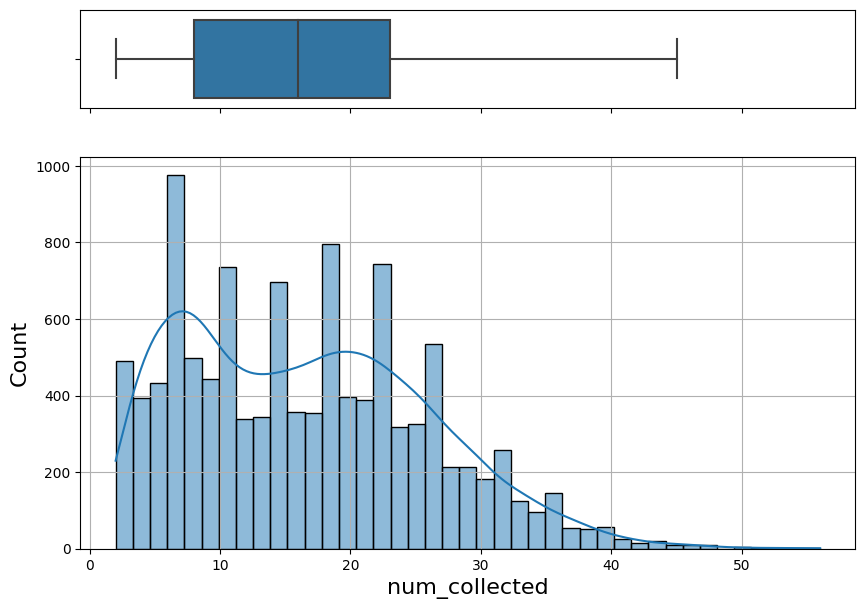

In [18]:
my_histogram(player_num_collected, "num_collected")

- Players' attributes are collected in different days.
- The player's characteristic data was collected 2 times for the fewest players and 56 times for the most players.
- I think we should use player attributes collected closest to match days.
- If the attributes don't change much, it seems possible to use summary statistics such as averages of attributes collected on different days for each player.


In [19]:
df_player_attr.isna().sum()

id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle     

<Axes: >

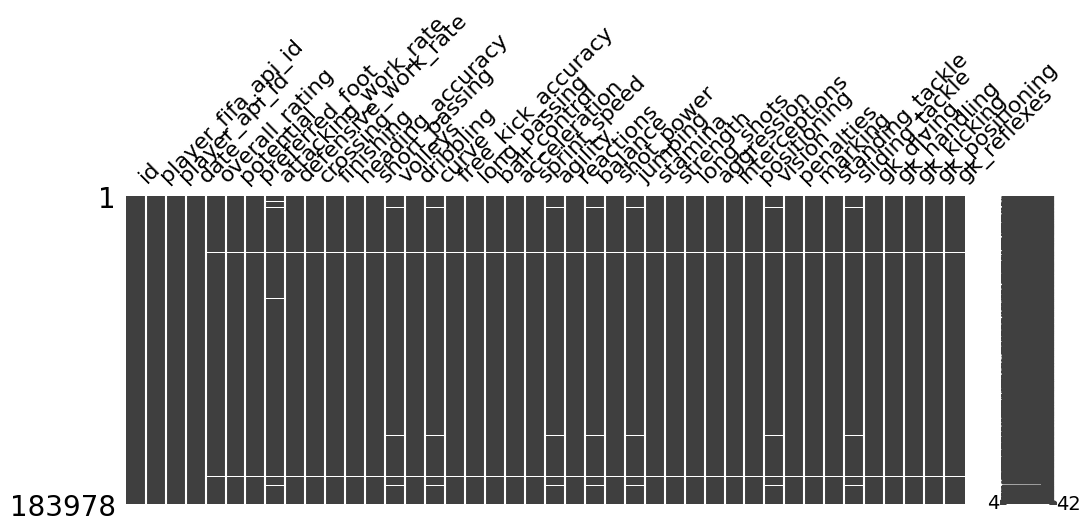

In [20]:
msno.matrix(df = df_player_attr, figsize = (12, 4))

- It looks like there are some patterns in missing values of the player attributes.
- If overall_rating is missing, then all other attributes are missing. This cases are only 0.4% (832 / 183978) of total data, so we can just drop this missing values later.
- There are cases where only some of the attributes have missing values. These cases should be considered later wheter to do impute appropriate values or drop.

## 1.2. Team related data

### 1.2.1. Country table

In [21]:
df_country = pd.read_sql(
    "select * from Country", con
    )

df_country

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


- There are total 11 countries

### 1.2.2. League table

In [22]:
df_league = pd.read_sql(
    "select * from League", con
    )

df_league

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


- There are total 11 leagues from different countries.
- Since there is only one league per country, country and league represent the same information.

### 1.2.3. Team table

In [23]:
df_team = pd.read_sql(
    "select * from Team", con
    )

df_team.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [24]:
df_team.shape

(299, 5)

In [25]:
len(df_team.team_api_id.unique())

299

In [26]:
len(df_team.team_fifa_api_id.unique())

286

In [27]:
df_team.isna().sum()

id                   0
team_api_id          0
team_fifa_api_id    11
team_long_name       0
team_short_name      0
dtype: int64

- team_api_id and team_fifa_api_id have different length because team_fifa_api_id has 11 missing values.
- So it is better to use team_api rather than use team_fifa_api_id to identify teams.
- There are 299 teams.

### 1.2.4. Team_Attributes table

In [28]:
df_team_attr = pd.read_sql(
    "select * from Team_Attributes", con
    )

df_team_attr.head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,Organised,60,Normal,65,Normal,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,Organised,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,Organised,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,Organised,70,Risky,70,Lots,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,Organised,53,Normal,48,Normal,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


In [29]:
df_team_attr.shape

(1458, 25)

- There are 21 team attributes.

In [30]:
len(df_team_attr.team_api_id.unique())

288

- The number of teams that have team attributes are 288 out of total 299 teams. 
- This is because the team attributes were collected by team_fifa_api_id, which has 11 missing values.
- Team attributes are important features, so I think matches of teams without team attributes should be excluded from the analysis.

In [31]:
team_num_collected = pd.DataFrame(df_team_attr.groupby("team_api_id").count().id)
team_num_collected.columns = ["num_collected"]
team_num_collected

,num_collected
team_api_id,
1601,6
1773,3
1957,6
2033,5
2182,6
...,...
10281,6
108893,6
158085,2


In [32]:
team_num_collected.describe()

,num_collected
count,288.000000
mean,5.062500
std,1.540255
min,1.000000
25%,5.000000
50%,6.000000
75%,6.000000
max,6.000000


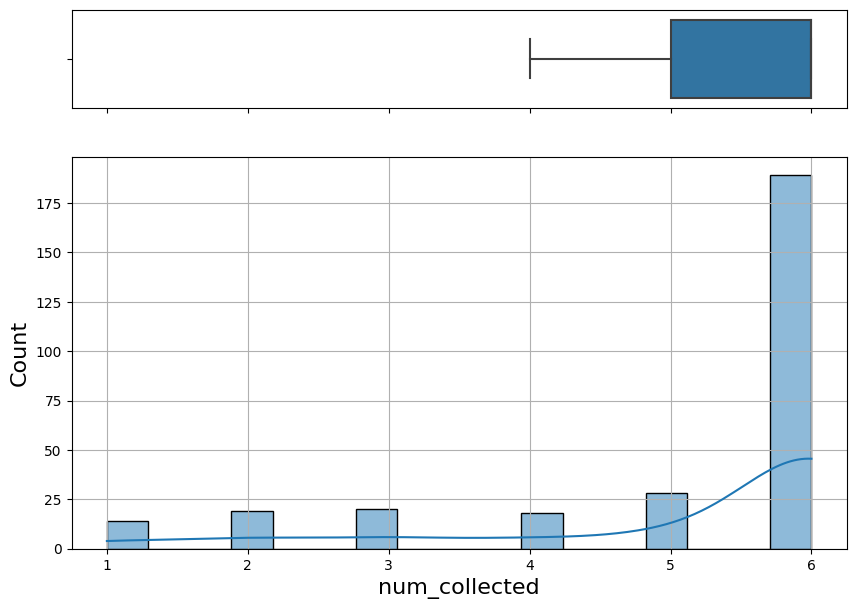

In [33]:
my_histogram(team_num_collected, "num_collected")

- For most teams, team attributes were collected 5 to 6 times.
- I think we should use team attributes collected closest to match days.
- If the attributes don't change much, it seems possible to use summary statistics such as averages of attributes collected on different days for each team.


In [34]:
df_team_attr.isna().sum()

id                                  0
team_fifa_api_id                    0
team_api_id                         0
date                                0
buildUpPlaySpeed                    0
buildUpPlaySpeedClass               0
buildUpPlayDribbling              969
buildUpPlayDribblingClass           0
buildUpPlayPassing                  0
buildUpPlayPassingClass             0
buildUpPlayPositioningClass         0
chanceCreationPassing               0
chanceCreationPassingClass          0
chanceCreationCrossing              0
chanceCreationCrossingClass         0
chanceCreationShooting              0
chanceCreationShootingClass         0
chanceCreationPositioningClass      0
defencePressure                     0
defencePressureClass                0
defenceAggression                   0
defenceAggressionClass              0
defenceTeamWidth                    0
defenceTeamWidthClass               0
defenceDefenderLineClass            0
dtype: int64

In [35]:
df_team_attr.shape

(1458, 25)

- There are no missing values for team attributes except for the buildUpPlayDribbling.
- 66% (969 / 1458) of the buildUpPlayDribbling attribute are missing values. So it seems to be better not to use this attribute.

## 1.3. Match table

In [36]:
df_match = pd.read_sql(
    "select * from Match", con
    )

df_match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.80,3.3,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.3,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.90,3.2,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.3,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.50,3.2,2.50,NaN,NaN,NaN,2.50,3.25,2.40,2.63,3.3,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,1.44,3.6,6.50,NaN,NaN,NaN,1.44,3.75,6.00,1.44,4.0,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,4.00,3.4,1.72,NaN,NaN,NaN,4.20,3.40,1.70,4.50,3.5,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [37]:
df_match.shape

(25979, 115)

In [38]:
print(df_match.columns.tolist())

['id', 'country_id', 'league_id', 'season', 'stage', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10', 'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1', 'home_player_2', 'home_player_

- There are 25,979 matches and 115 match information variables.
- Match information is consist of 5 category
    - basic match information
        - country id, league id
        - home team id, away team id
        - season, stage, date
    - in game information
        - goal, shoton, shotoff
        - foulcommit, card
        - cross, corner
        - possession
    - match result
        - home_team_goal, away_team_goal
    - player 
        - home team players, away team players
    - betting information

In [39]:
basic_match_information_col = ["country_id", "league_id", "home_team_api_id", "away_team_api_id", "season", "stage", "date"]
in_game_col = ['goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession']
match_result_col = ["home_team_goal", "away_team_goal"]
player_col = ['home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 
              'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10', 
              'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 
              'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 
              'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 
              'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 
              'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 
              'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 
              'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1', 
              'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 
              'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 
              'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4', 'away_player_5', 
              'away_player_6', 'away_player_7', 'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11']
betting_col = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 
               'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 
               'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA']

### 1.3.1. Basic match information

In [40]:
df_match[basic_match_information_col].isna().sum()

country_id          0
league_id           0
home_team_api_id    0
away_team_api_id    0
season              0
stage               0
date                0
dtype: int64

- There are no missiing values in the basic match information related columns.

### 1.3.2. In-game information

In [41]:
df_match[in_game_col].goal.unique()[1]

'<goal><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>406</event_incident_typefk><elapsed>22</elapsed><player2>38807</player2><subtype>header</subtype><player1>37799</player1><sortorder>5</sortorder><team>10261</team><id>378998</id><n>295</n><type>goal</type><goal_type>n</goal_type></value><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>393</event_incident_typefk><elapsed>24</elapsed><player2>24154</player2><subtype>shot</subtype><player1>24148</player1><sortorder>4</sortorder><team>10260</team><id>379019</id><n>298</n><type>goal</type><goal_type>n</goal_type></value></goal>'

- In-game information is consist of xml data. We need to extract information from the xml data. (data description: https://docs.google.com/spreadsheets/d/1EIwJc1YxI5Uf1-gNGdjgmreI0JLSSicH/edit?usp=sharing&ouid=103945379872439212801&rtpof=true&sd=true)

In [42]:
df_match[in_game_col].card.unique()[1]

'<card><value><comment>y</comment><stats><ycards>1</ycards></stats><event_incident_typefk>73</event_incident_typefk><elapsed>78</elapsed><card_type>y</card_type><subtype>serious_fouls</subtype><player1>24157</player1><sortorder>1</sortorder><team>10260</team><n>342</n><type>card</type><id>379481</id></value><value><comment>y</comment><stats><ycards>1</ycards></stats><event_incident_typefk>73</event_incident_typefk><elapsed>82</elapsed><card_type>y</card_type><subtype>serious_fouls</subtype><player1>30362</player1><sortorder>1</sortorder><team>10260</team><n>346</n><type>card</type><id>379503</id></value><value><comment>y</comment><stats><ycards>1</ycards></stats><event_incident_typefk>70</event_incident_typefk><elapsed>90</elapsed><card_type>y</card_type><player1>30829</player1><sortorder>1</sortorder><team>10260</team><n>353</n><type>card</type><id>379547</id></value></card>'

In [43]:
tree = ET.fromstring(df_match[in_game_col].goal.unique()[1])

### 1.3.3. Match result information

In [44]:
df_match[match_result_col].isna().sum()

home_team_goal    0
away_team_goal    0
dtype: int64

- There is no missing value in the match results related columns.

### 1.3.4. Player information

In [45]:
df_match[player_col].isna().sum()

home_player_X1    1821
home_player_X2    1821
home_player_X3    1832
home_player_X4    1832
home_player_X5    1832
                  ... 
away_player_7     1235
away_player_8     1341
away_player_9     1328
away_player_10    1441
away_player_11    1554
Length: 66, dtype: int64

<Axes: >

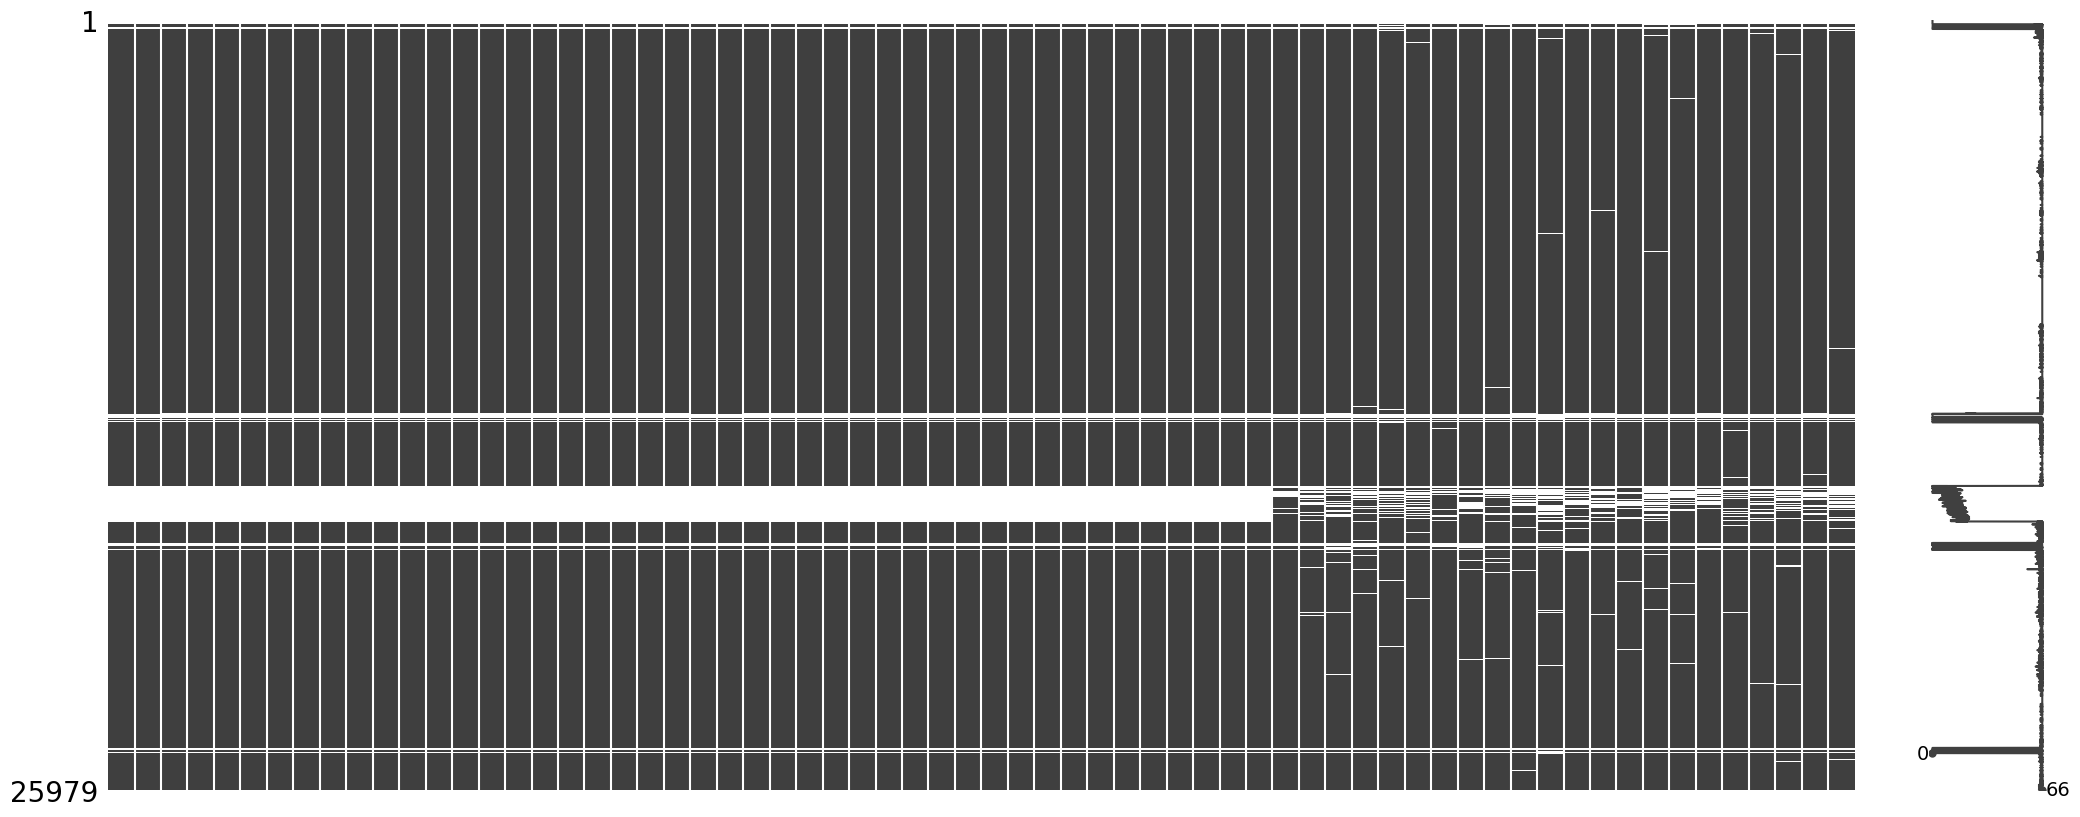

In [46]:
msno.matrix(df_match[player_col])

### 1.3.5. Betting information